In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
from nilearn.image import mean_img , index_img
from nilearn.glm import first_level , threshold_stats_img
import warnings
warnings.filterwarnings('ignore')

In [6]:
img_path = r'C:\Users\Nafir\Documents\Python in Neuroimaging\data'
fmri_img = [nib.load(img_path + '\\' + img) for img in os.listdir(img_path)]
event_path = r'C:\Users\Nafir\Documents\Python in Neuroimaging\tsv'
events = [pd.read_table(event_path + '\\' + table) for table in os.listdir(event_path)]

In [8]:
events

[      onset  duration  circle_duration   stim_type  trigger  button_pushed  \
 0     0.000     0.851            0.585  UNFAMILIAR       13              7   
 1     3.056     0.812            0.447  UNFAMILIAR       14              7   
 2     6.364     0.915            0.580  UNFAMILIAR       13              7   
 3     9.604     0.940            0.514  UNFAMILIAR       13              4   
 4    12.828     0.985            0.515  UNFAMILIAR       13              7   
 ..      ...       ...              ...         ...      ...            ...   
 94  382.753     0.894            0.519   SCRAMBLED       17              7   
 95  385.943     0.850            0.528   SCRAMBLED       17              4   
 96  388.951     0.830            0.401   SCRAMBLED       18              4   
 97  392.057     0.993            0.506   SCRAMBLED       19              7   
 98  394.846     0.012            0.000         NaN      999              0   
 
     response_time        stim_file  
 0          

In [26]:
for i ,event in enumerate(events):
    event.rename(columns={'stim_type': 'trial_type'}, inplace=True)
    events[i] = event.dropna()

In [28]:
tr = 2.0  
n_scans = fmri_img[0].shape[3] 
frame_times = np.arange(n_scans) * tr

In [30]:
design_metrics = [first_level.make_first_level_design_matrix(frame_times, event[['onset', 'duration', 'trial_type']],drift_model = 'Cosine',high_pass = 0.01,hrf_model = 'spm') for event in events]

## Test different HRF

In [18]:
import seaborn as sns

<Axes: >

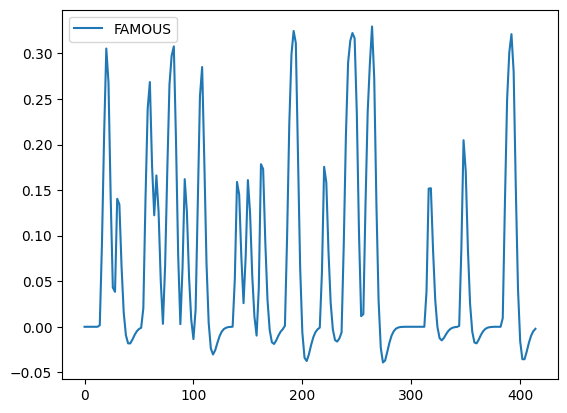

In [39]:
sns.lineplot(design_metrics[1][['FAMOUS']]) ### spm + derivative

<Axes: >

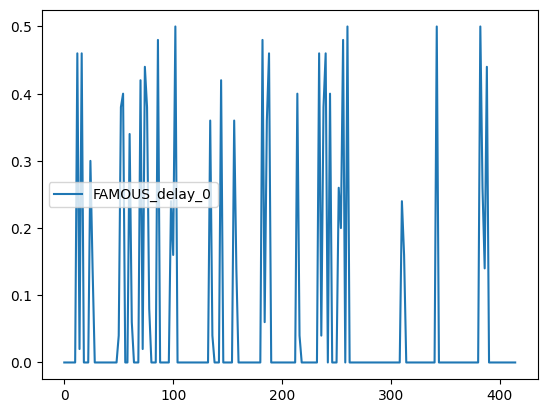

In [48]:
design_metrics = [first_level.make_first_level_design_matrix(frame_times, event[['onset', 'duration', 'trial_type']],drift_model = 'Cosine',high_pass = 0.01,hrf_model = 'fir') for event in events]
sns.lineplot(design_metrics[1][['FAMOUS_delay_0']]) ### fir
#design_metrics[1]

<Axes: >

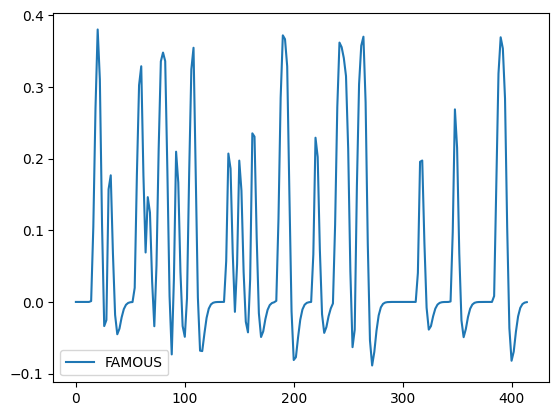

In [54]:
design_metrics = [first_level.make_first_level_design_matrix(frame_times, event[['onset', 'duration', 'trial_type']],drift_model = 'Cosine',high_pass = 0.01,hrf_model = 'glover') for event in events]
sns.lineplot(design_metrics[1][['FAMOUS']]) ### glover
#design_metrics[1]

<Axes: >

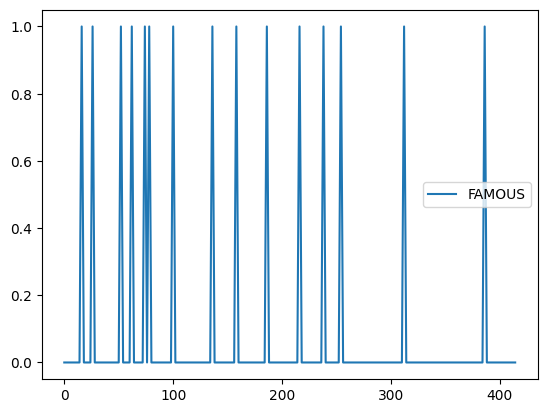

In [58]:
design_metrics = [first_level.make_first_level_design_matrix(frame_times, event[['onset', 'duration', 'trial_type']],drift_model = 'Cosine',high_pass = 0.01,hrf_model = None) for event in events]
sns.lineplot(design_metrics[1][['FAMOUS']]) ### None
#design_metrics[1]

#### Try for a region 

In [85]:
from nilearn.maskers import NiftiLabelsMasker
from nilearn import datasets

atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
masker = NiftiLabelsMasker(
    atlas.maps,
    labels=atlas.labels,
    standardize="zscore_sample",
)
masker.fit()
masker.fit(fmri_img[0])
timeser = masker.transform(fmri_img[0])


<Axes: >

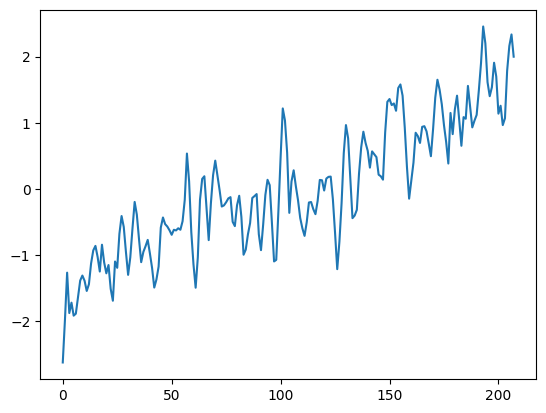

In [86]:

sns.lineplot(timeser[: , -1])


## Continue

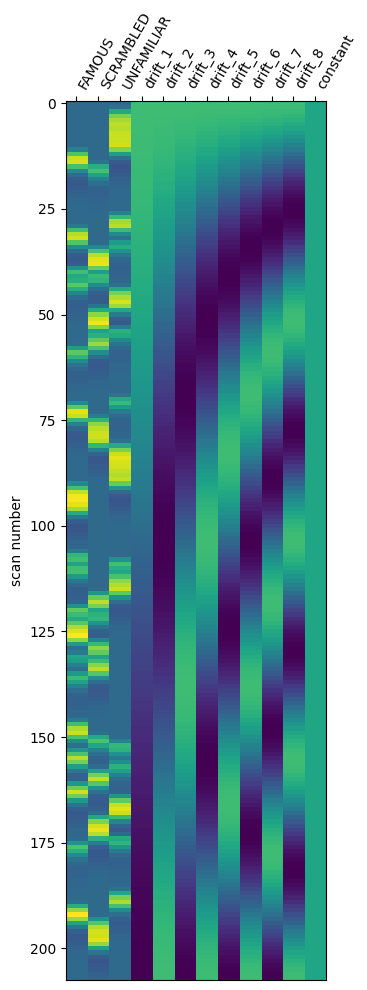

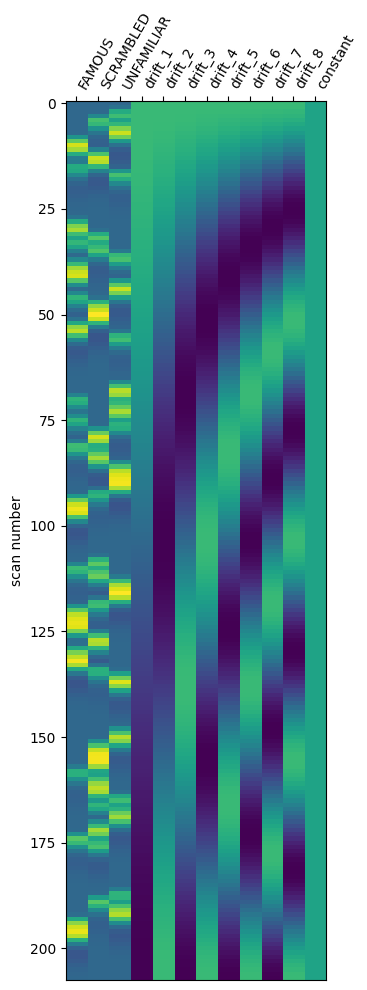

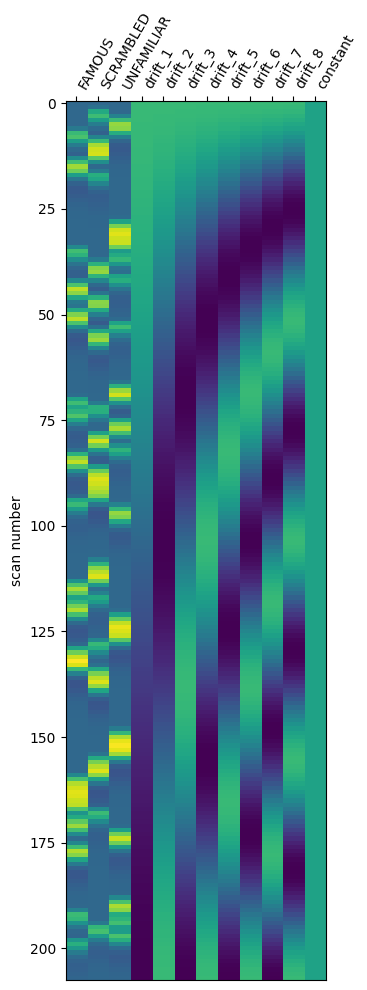

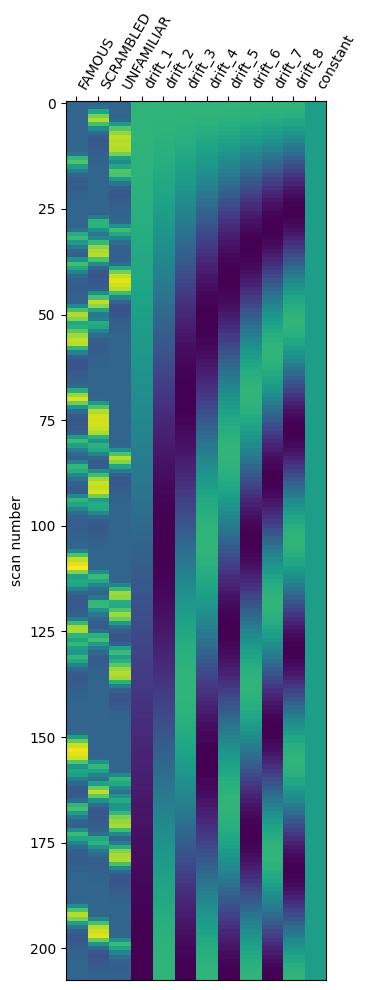

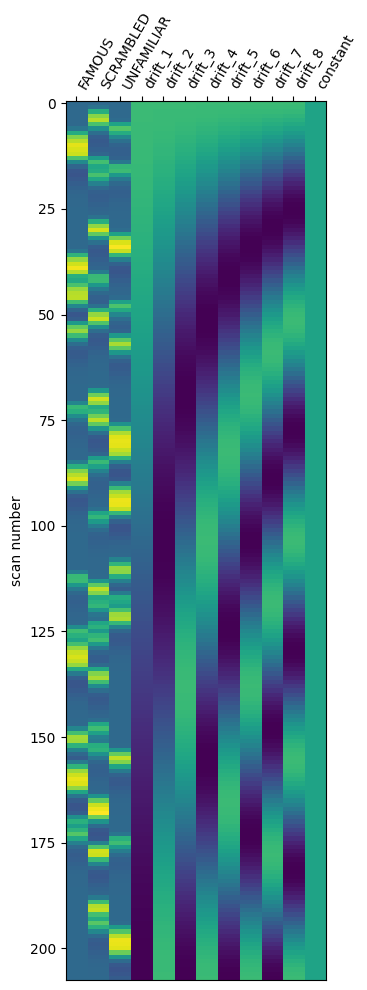

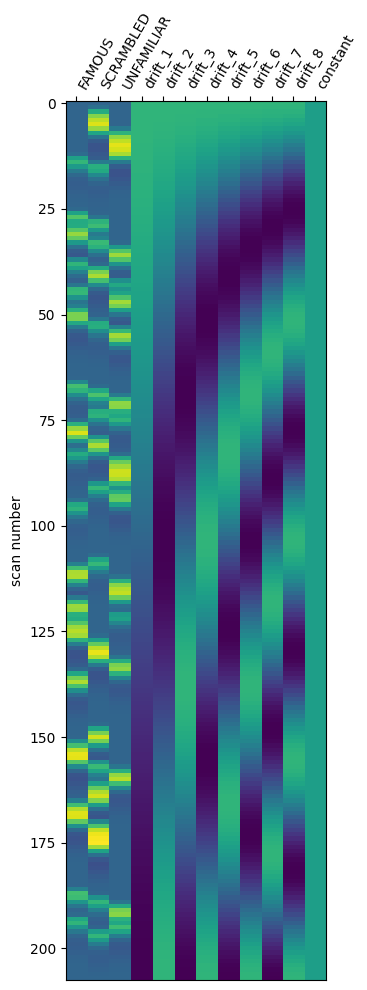

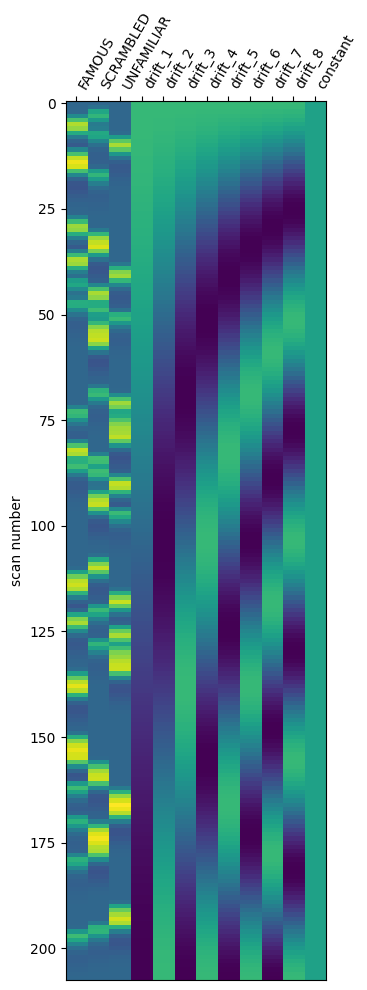

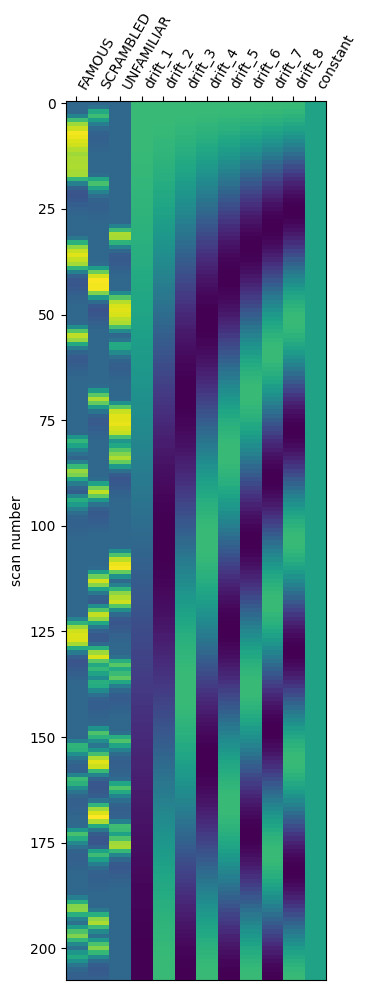

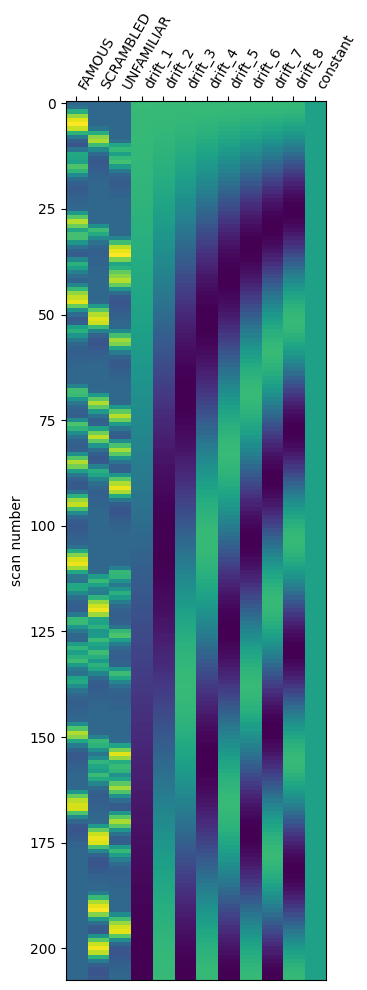

In [15]:
for i in design_metrics:
    plotting.plot_design_matrix(i)
    plotting.show()

In [32]:
contrast = np.eye(design_metrics[1].shape[1])

In [34]:
contrast

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [36]:
base_cont = {}
for i, condition in enumerate(design_metrics[1].columns):
    base_cont[condition] =  contrast[i]

In [38]:
base_cont

{'FAMOUS': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'SCRAMBLED': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'UNFAMILIAR': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_1': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_2': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_3': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'drift_4': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'drift_5': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 'drift_6': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 'drift_7': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'drift_8': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 'constant': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}

In [40]:
contrasts = {
    "FAMOUS > SCRAMBLED": base_cont["FAMOUS"] - base_cont["SCRAMBLED"],
    "UNFAMILIAR > SCRAMBLED": base_cont["UNFAMILIAR"] - base_cont["SCRAMBLED"],
    "FAMOUS > UNFAMILIAR": base_cont["FAMOUS"] - base_cont["UNFAMILIAR"],
    "Face > SCRAMBLED": (base_cont["UNFAMILIAR"] + base_cont["FAMOUS"])/2 - base_cont["SCRAMBLED"],
}

In [42]:
contrasts

{'FAMOUS > SCRAMBLED': array([ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'UNFAMILIAR > SCRAMBLED': array([ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'FAMOUS > UNFAMILIAR': array([ 1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'Face > SCRAMBLED': array([ 0.5, -1. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ])}

<Axes: label='conditions'>

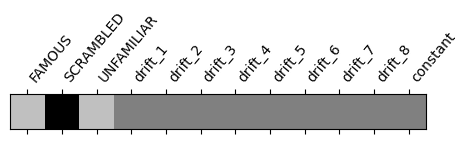

In [29]:
plotting.plot_contrast_matrix(contrasts['Face > SCRAMBLED'], design_matrix= design_metrics[1])

In [44]:
fmri_glm = first_level.FirstLevelModel()
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_metrics)

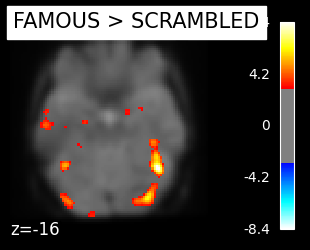

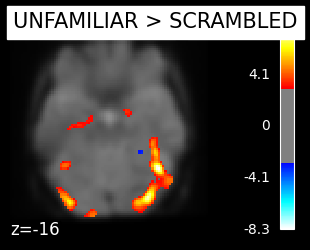

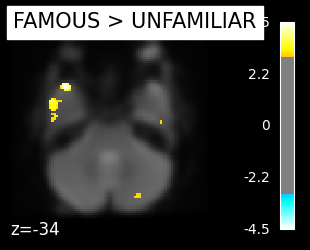

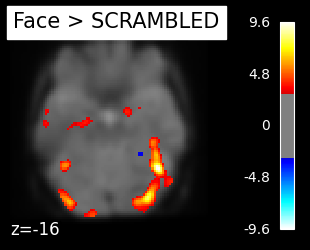

In [33]:
for contrast_id, contrast_val in contrasts.items():
    z_map = fmri_glm.compute_contrast(contrast_val, output_type="z_score")
    plotting.plot_stat_map(
        z_map,
        bg_img=mean_img(fmri_img),
        threshold=3.0,
        display_mode="z",
        cut_coords=1,
        black_bg=True,
        title=contrast_id,
    )
    plotting.show()

In [24]:
for i, event in enumerate(events):
    print(f'event{i+ 1} is ')

event1 is 
event2 is 
event3 is 
event4 is 
event5 is 
event6 is 
event7 is 
event8 is 
event9 is 
